W tym zadaniu nadal będziemy pracować na danych dotyczących rodzajów fonacji. Tym razem zajmiemy się problem klasyfikacji wieloklasowej.

W macierzy zawierającej cechy ponownie mamy 13 MFCC i ich I i II pochodną. Sygnałów jest 909 i przynależą do 5 klas:

0. neutral - z nastawieniem miękkim
1. pressed - z nastawieniem twardym, typ I
2. pressedta - z nastawieniem twardym, typ II (wg autorów bazy "while pressed vocalization was achieved by raising the larynx, pressedta was an attepmt to raise the subglottal pressure directly, without raising the larynx")
3. breathy - z nastawieniem chuchającym
4. flow - "phonation type produced with the largest peak-to-peak flow amplitude, where the minimum still reaches zero"

In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, accuracy_score, f1_score, make_scorer, confusion_matrix, log_loss
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
import optuna
from sklearn.model_selection import cross_validate, StratifiedKFold
import pickle
from collections import Counter

In [19]:
#wczytywanie danych
X = np.load('padded_feats.npy') #macierz cech - jednej wiersz = jeden obiekt
y = np.load('labels.npy') #labele
print(y)

[3 2 4 0 3 0 1 3 3 1 4 0 2 3 2 3 2 4 3 0 2 4 0 3 2 2 0 4 2 2 0 0 2 1 3 3 0
 3 0 1 0 3 1 4 4 0 3 0 1 3 1 2 3 3 0 0 2 4 2 2 3 0 2 3 2 3 1 4 1 2 3 1 4 1
 0 2 3 0 4 3 4 1 1 4 0 1 2 4 2 3 4 3 2 0 1 0 3 2 4 3 2 3 0 0 3 0 2 0 4 0 0
 3 2 4 3 0 3 2 3 0 0 1 4 4 3 0 0 0 4 3 0 4 3 3 2 4 4 3 1 1 0 1 2 1 0 0 1 1
 1 0 4 1 2 3 2 0 1 3 0 1 2 0 1 0 4 3 0 0 2 4 0 2 4 0 2 3 1 0 3 4 3 0 0 3 2
 0 3 4 1 1 4 3 3 3 0 3 2 0 2 3 1 0 3 1 2 3 0 0 2 1 1 0 0 0 3 3 3 1 3 0 2 3
 1 3 1 2 4 3 3 4 1 4 3 4 2 1 2 2 4 2 3 3 0 2 1 2 3 3 3 3 0 3 0 3 3 2 4 3 0
 0 0 0 4 2 2 2 2 0 0 0 3 2 3 3 3 4 0 4 4 3 1 0 4 1 0 4 1 1 4 3 2 3 2 4 4 1
 1 3 3 3 4 3 3 3 4 3 2 0 3 3 3 3 1 2 2 4 2 3 3 3 3 3 4 2 3 2 3 3 3 1 4 1 0
 0 1 0 4 2 4 1 3 0 4 1 0 2 2 0 1 3 3 3 4 3 3 0 4 1 2 0 0 0 2 3 4 3 0 4 1 0
 0 0 0 2 0 4 2 1 1 0 1 4 3 0 2 3 1 1 2 1 3 3 2 0 3 4 1 3 0 0 4 0 3 0 0 3 2
 1 3 0 3 4 1 0 4 1 1 0 0 3 4 0 4 4 3 0 4 3 3 4 3 4 0 0 4 1 0 3 2 3 2 3 3 4
 4 2 2 1 3 0 1 0 0 3 0 3 3 2 1 4 2 4 0 2 0 0 3 1 0 3 2 2 1 2 0 4 3 0 4 0 0
 3 0 0 1 3 4 3 1 0 2 1 1 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42) #podział na zbiory

In [21]:
scaler = StandardScaler().fit(X_train) #standaryzacja
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
SVM = SVC(C=1.0, random_state=42)
SVM.fit(X_train, y_train)

SVC(random_state=42)

Klasyfikację wykonuje się tak samo bez względu na to, ile klas jest w zbiorze. Należy użyć metody fit na zbiorze uczącym, a następnie predict na zbiorze testowym. Różnica jest w obliczaniu metryk - większość z nich wymaga określenia, która klasa jest pozytywna, a która negatywna. Gdy mamy więcej niż 2 klasy, metryki wylicza się uśredniając wyniki uzyskane dla każdej z klas (zazwyczaj przy założeniu, że jest aktualnie rozpatrywana klasa jest pozytywna, a pozostałe negatywne). Trzeba określić, w jaki sposób będzie wyliczana średnia. Można wybrać trzy rodzaje:

- weighted - średnia ważona, najlepsza, gdy mamy nierównoliczne klasy
- macro - średnia arytmetyczna, a nie ważona
- micro  - wynik wyznaczony globalnie poprzez zliczenie wszystkich TP, FP i FN (od razu dla całych danych, a nie dla każdej klasy z osobna).

Policzmy, ile mamy obiektów w każdej z klas w zbiorze testowym, żeby wybrać sposób uśredniania przy liczeniu metryk.

<BarContainer object of 5 artists>

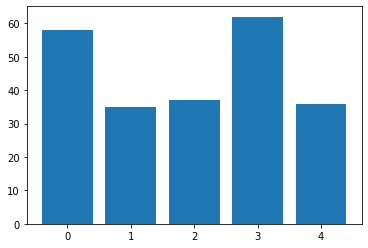

In [23]:
counter_ytest = Counter(y_test)
plt.bar(counter_ytest.keys(), counter_ytest.values())

Jak widać, klasy nie są równolicze, np. klasy 3 jest prawie 2x więcej niż klasy 1. Dlatego użyjemy średniej ważonej.

In [24]:
SVM_test_preds = SVM.predict(X_test)
print('test accuracy = ', accuracy_score(y_test, SVM_test_preds))
print('test F1 = ', f1_score(y_test, SVM_test_preds, average='weighted'))
print(confusion_matrix(y_test, SVM_test_preds))

test accuracy =  0.47368421052631576
test F1 =  0.36968016633760686
[[44  0  0 14  0]
 [ 2  0  7 26  0]
 [ 2  0  9 26  0]
 [ 7  0  0 55  0]
 [31  0  0  5  0]]


Macierz pomyłek jest dużo bardziej rozbudowana, niż w przypadku klasyfikacji binarnej. Da się z niej odczytać nie tylko, które obiekty zostały zaklasyfikowane poprawnie (wartości na przekątnej), ale też spradzić, do której konkretnie klasy zostały przyporządkowane te, które zaklasyfikowano nieprawidłowo.

Dokładność i F1 uzyskane przy domyślnej wartości C=1 nie są zbyt dobre i model nie nauczył się prawidłowo klasyfikować obiektów. Widać to też na podstawie macierzy pomyłek - żaden obiekt z klasy 1 i 4 nie został zaklasyfikowany prawidłowo, a najwięcej zaklasyfikowano do klasy 3.

To była klasyfikacja na danych nieustandaryzowanych. Przeprowadź teraz klasyfikację używając X_train_scaled i X_test_scaled.

In [25]:
SVM_scaled = SVC(C=1.0, random_state=42)
SVM_scaled.fit(X_train_scaled, y_train)
SVM_test_preds = SVM_scaled.predict(X_test_scaled)
print('test accuracy = ', accuracy_score(y_test, SVM_test_preds))
print('test F1 = ', f1_score(y_test, SVM_test_preds, average='weighted'))
print(confusion_matrix(y_test, SVM_test_preds))

test accuracy =  0.8070175438596491
test F1 =  0.8054811520887298
[[45  1  0  7  5]
 [ 3 25  6  0  1]
 [ 2  8 26  0  1]
 [ 2  0  0 60  0]
 [ 5  3  0  0 28]]


Żeby spróbować jeszcze bardziej poprawić wyniki, trzeba zoptymalizować model. Robi się to tak samo, jak w zadaniu poprzednim z jedną różnicą - w przypadku modeli regresyjnych i klasyfikatorów binarnych funkcją celu może być ROC AUC, natomiast w przypadku większej liczby klas trzeba wybrać inną metrykę. Najczęściej jest to czułość (accuracy) lub F1. Zacznijmy od F1, które teoretycznie jest lepszą metryką, bo zawiera w sobie precyzję i czułość.

In [26]:
scoring = {'f1_macro': make_scorer(f1_score, average='weighted')}

Zdefiniuj pozostałe potrzebne funkcje i zmienne: funkcję objective, model, space i trials. Zoptymalizyj model i wylicz dokładność, F1 i wyznacz macierz pomyłek.

In [27]:
def get_space(trial): 
    space = {"C": trial.suggest_uniform("C", 0, 1), 
           "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
            'degree': trial.suggest_int('degree', 1,3)}
    return space

def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_f1_macro'])
model = SVC
trials = 10
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials)

[I 2022-12-19 22:29:23,562] A new study created in memory with name: no-name-4e34f639-8f2a-450d-9c5d-ed3c1b58e9ab
C:\Users\jakub\AppData\Local\Temp\ipykernel_11020\965075820.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2022-12-19 22:33:26,477] Trial 0 finished with value: 0.7148108734517468 and parameters: {'C': 0.38560771739462496, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.7148108734517468.


In [28]:
SVM_scaled = SVC(**study.best_params)
SVM_scaled.fit(X_train_scaled, y_train)
SVM_test_preds = SVM_scaled.predict(X_test_scaled)
print('test accuracy = ', accuracy_score(y_test, SVM_test_preds))
print('test F1 = ', f1_score(y_test, SVM_test_preds, average='weighted'))
print(confusion_matrix(y_test, SVM_test_preds))

test accuracy =  0.7631578947368421
test F1 =  0.7587828977983683
[[47  1  0  8  2]
 [ 3 23  7  1  1]
 [ 3 11 21  2  0]
 [ 2  0  0 60  0]
 [ 9  4  0  0 23]]


Powtórz proces optymalizacji dla funkcji celu zdefiniowanej przez dokładność. Która dała lepsze wyniki? Jak bardzo udało się poprawić wyniki w porównaniu do nieoptymalizowanego modelu?

In [29]:
scoring = {'accuracy_macro': make_scorer(accuracy_score)}

In [30]:
def get_space(trial): 
    space = {"C": trial.suggest_uniform("C", 0, 1), 
           "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
            'degree': trial.suggest_int('degree', 1,3)}
    return space

def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_accuracy_macro'])
model = SVC
trials = 10
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials)

[I 2022-12-19 22:34:08,943] A new study created in memory with name: no-name-7e56e1b9-b867-4157-b964-380844a614e3
C:\Users\jakub\AppData\Local\Temp\ipykernel_11020\2373404125.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2022-12-19 22:36:52,396] Trial 0 finished with value: 0.7944289394589953 and parameters: {'C': 0.8898434776093302, 'kernel': 'sigmoid', 'degree': 3}. Best is trial 0 with value: 0.7944289394589953.


In [31]:
SVM_scaled = SVC(**study.best_params)
SVM_scaled.fit(X_train_scaled, y_train)
SVM_test_preds = SVM_scaled.predict(X_test_scaled)
print('test accuracy = ', accuracy_score(y_test, SVM_test_preds))
print('test F1 = ', f1_score(y_test, SVM_test_preds, average='weighted'))
print(confusion_matrix(y_test, SVM_test_preds))

test accuracy =  0.8114035087719298
test F1 =  0.8104435064450367
[[47  1  0  8  2]
 [ 3 25  5  0  2]
 [ 0 10 25  1  1]
 [ 2  0  0 60  0]
 [ 4  4  0  0 28]]
